# Denoising via SVD

In [115]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [171]:
def plotting(flower,noise_flower,reconstruction):
  plt.subplot(1,4,1)
  plt.imshow(flower, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
  plt.title("flower")
  plt.axis("off")
  plt.subplot(1,4,2)
  plt.imshow(noise_flower, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
  plt.title("noise_flower")
  plt.axis("off")
  plt.subplot(1,4,3)
  plt.imshow(reconstruction, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
  plt.title("reconstruction")
  plt.axis("off")
  plt.subplot(1,4,4)
  difference = flower - reconstruction
  plt.title("difference")
  plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation="nearest")
  plt.axis("off")

  plt.show()

In [162]:
def denoising(matrix, k):
    U, S, Vh = np.linalg.svd(matrix, full_matrices=True)
    denoising = U[:, :k]@(np.diag(S[:k])@Vh[:k, :])
    denoising = np.clip(denoising, 0, 255).astype(np.uint8)
    return denoising

In [163]:
import os

data = []

for filename in os.listdir('drive/MyDrive/flowers'):
  data.append('drive/MyDrive/flowers/'+filename)

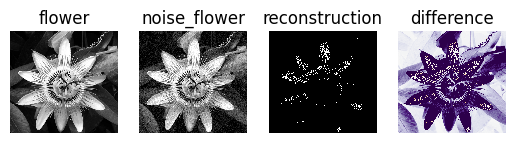

In [212]:
flower = cv2.imread(data[3],cv2.IMREAD_GRAYSCALE)

flower = flower / 255.0
height, width = flower.shape
noise_flower = flower.copy()
noise_flower += 0.075 * np.random.randn(height, width)

denoised_flower = denoising(noise_flower, k = 300)

plotting(flower,noise_flower,denoised_flower)

# Denoising via dictionary learning

In [173]:
from time import time

from sklearn.feature_extraction.image import extract_patches_2d

t0 = time()
patch_size = (7, 7)
data_flower = extract_patches_2d(noise_flower, patch_size)
data_flower = data_flower.reshape(data_flower.shape[0], -1)
data_flower -= np.mean(data_flower, axis=0)
data_flower /= np.std(data_flower, axis=0)
print(f"{data_flower.shape[0]} patches extracted in %.2fs." % (time() - t0))

259350 patches extracted in 0.33s.


Learning the dictionary...
1.0 iterations / 111 steps in 26.39.


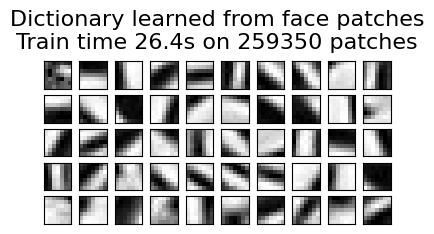

In [217]:
from sklearn.decomposition import MiniBatchDictionaryLearning

print("Learning the dictionary...")
t0 = time()
dico = MiniBatchDictionaryLearning(
    n_components=50,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
)
V = dico.fit(data_flower).components_
dt = time() - t0
print(f"{dico.n_iter_} iterations / {dico.n_steps_} steps in {dt:.2f}.")

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(data_flower)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

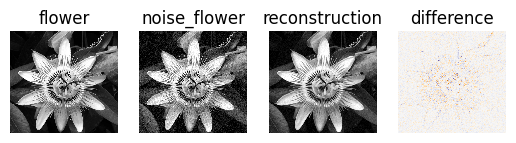

In [218]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

data_flower = extract_patches_2d(noise_flower, patch_size)
data_flower = data_flower.reshape(data_flower.shape[0], -1)
intercept = np.mean(data_flower, axis=0)
data_flower -= intercept

dico.set_params(transform_algorithm="omp")
code = dico.transform(data_flower)
patches = np.dot(code, V)

patches += intercept
patches = patches.reshape(len(data_flower), *patch_size)
reconstruction = reconstruct_from_patches_2d(patches, (height, width))

plotting(flower,noise_flower,reconstruction)

In [179]:
def dictionary_learning(noise_flower):
  patch_size = (7, 7)
  data_flower = extract_patches_2d(noise_flower, patch_size)
  data_flower = data_flower.reshape(data_flower.shape[0], -1)
  intercept = np.mean(data_flower, axis=0)
  data_flower -= intercept

  dico = MiniBatchDictionaryLearning(
    n_components=50,
    batch_size=200,
    alpha=1.0,
    max_iter=10,)
  V = dico.fit(data_flower).components_

  dico.set_params(transform_algorithm="omp")
  code = dico.transform(data_flower)
  patches = np.dot(code, V)

  patches += intercept
  patches = patches.reshape(len(data_flower), *patch_size)
  reconstruction = reconstruct_from_patches_2d(patches, (height, width))

  return reconstruction

# Denoising via k-svd

In [146]:
! pip install ksvd

In [214]:
from ksvd import ApproximateKSVD

aksvd = ApproximateKSVD(n_components=50)
dictionary = aksvd.fit(data_flower).components_
gamma = aksvd.transform(data_flower)

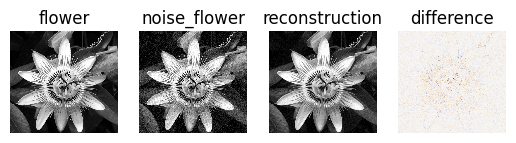

In [215]:
patches = gamma.dot(dictionary)
patches += intercept
patches = patches.reshape(len(data_flower), *patch_size)
reconstruction = reconstruct_from_patches_2d(patches, (height, width))

plotting(flower,noise_flower,reconstruction)

In [220]:
def k_svd(noise_flower,ps=7,n_c=50):
  patch_size = (ps, ps)
  data_flower = extract_patches_2d(noise_flower, patch_size)
  data_flower = data_flower.reshape(data_flower.shape[0], -1)
  intercept = np.mean(data_flower, axis=0)
  data_flower -= intercept

  aksvd = ApproximateKSVD(n_components=n_c)
  dictionary = aksvd.fit(data_flower).components_
  gamma = aksvd.transform(data_flower)

  patches = gamma.dot(dictionary)
  patches += intercept
  patches = patches.reshape(len(data_flower), *patch_size)
  reconstruction = reconstruct_from_patches_2d(patches, (height, width))

  return reconstruction

# Comparison

In [183]:
from skimage import metrics
psnr_noisy = metrics.peak_signal_noise_ratio

In [ ]:
psnr2,psnr3 =[],[],[]
mse2,mse3 =[],[],[]
for i in data[:5]:
  flower = cv2.imread(i,cv2.IMREAD_GRAYSCALE)

  flower = flower / 255.0
  height, width = flower.shape
  noise_flower = flower.copy()
  noise_flower += 0.075 * np.random.randn(height, width)

  dict_flower = dictionary_learning(noise_flower)
  k_svd_flower = k_svd(noise_flower)

  psnr2.append(metrics.peak_signal_noise_ratio(np.array(flower),np.array(dict_flower)))
  psnr3.append(metrics.peak_signal_noise_ratio(np.array(flower),np.array(k_svd_flower)))

  mse2.append(metrics.mean_squared_error(np.array(flower),np.array(dict_flower)))
  mse3.append(metrics.mean_squared_error(np.array(flower),np.array(k_svd_flower)))

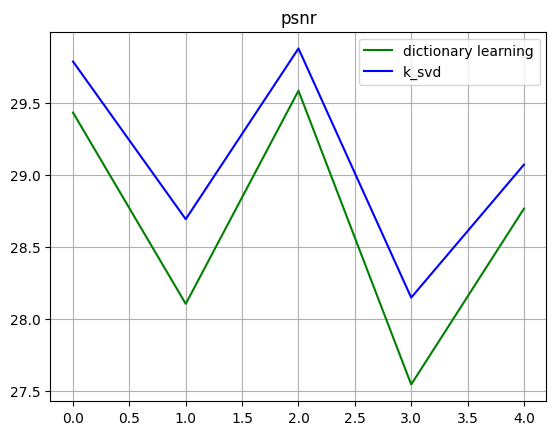

In [223]:
plt.plot(range(len(data[:5])),psnr2,'g',range(len(data[:5])),psnr3,'b')
plt.legend(["dictionary learning", "k_svd"])
plt.grid()
plt.title("psnr")
plt.show()

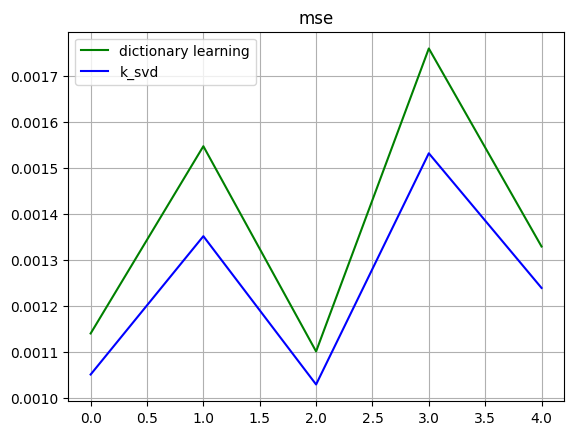

In [224]:
plt.plot(range(len(data[:5])),mse2,'g',range(len(data[:5])),mse3,'b')
plt.legend(["dictionary learning", "k_svd"])
plt.grid()
plt.title("mse")
plt.show()

# Parameters of k-svd

In [226]:
def k_svd(noise_flower,ps=7,n_c=50):
  patch_size = (ps, ps)
  data_flower = extract_patches_2d(noise_flower, patch_size)
  data_flower = data_flower.reshape(data_flower.shape[0], -1)
  intercept = np.mean(data_flower, axis=0)
  data_flower -= intercept

  aksvd = ApproximateKSVD(n_components=n_c)
  dictionary = aksvd.fit(data_flower[:10000]).components_
  gamma = aksvd.transform(data_flower)

  patches = gamma.dot(dictionary)
  patches += intercept
  patches = patches.reshape(len(data_flower), *patch_size)
  reconstruction = reconstruct_from_patches_2d(patches, (height, width))

  return reconstruction

In [ ]:
ps_arr1=[]
ps_arr2=[]
for ps in [7,10,15,20]:
  k_svd_flower = k_svd(noise_flower,ps)

  ps_arr1.append(metrics.peak_signal_noise_ratio(np.array(flower),np.array(k_svd_flower)))
  ps_arr2.append(metrics.mean_squared_error(np.array(flower),np.array(k_svd_flower)))

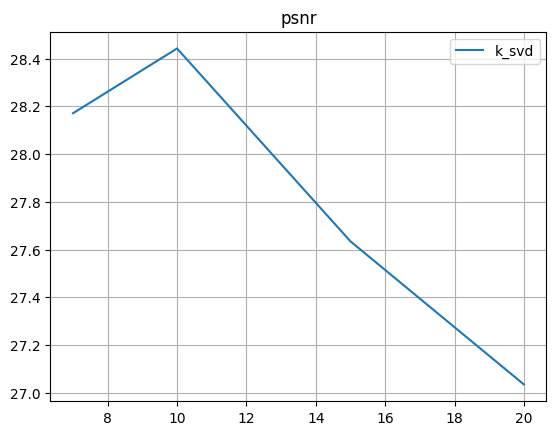

In [229]:
plt.plot([7,10,15,20],ps_arr1)
plt.legend(["k_svd"])
plt.grid()
plt.title("psnr")
plt.show()

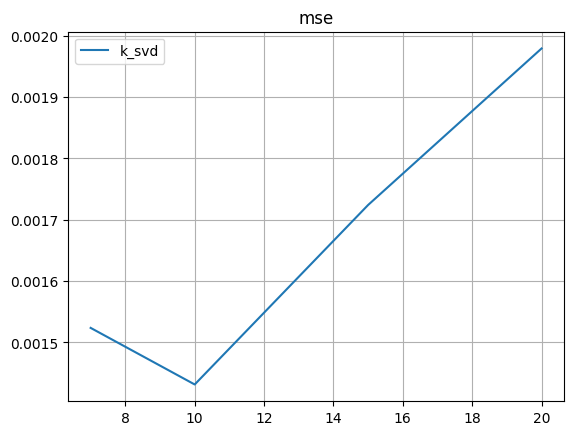

In [230]:
plt.plot([7,10,15,20],ps_arr2)
plt.legend(["k_svd"])
plt.grid()
plt.title("mse")
plt.show()

In [236]:
ps_arr1=[]
ps_arr2=[]
for nc in [10,20,30,40,50]:
  k_svd_flower = k_svd(noise_flower,ps=10,n_c=nc)

  ps_arr1.append(metrics.peak_signal_noise_ratio(np.array(flower),np.array(k_svd_flower)))
  ps_arr2.append(metrics.mean_squared_error(np.array(flower),np.array(k_svd_flower)))

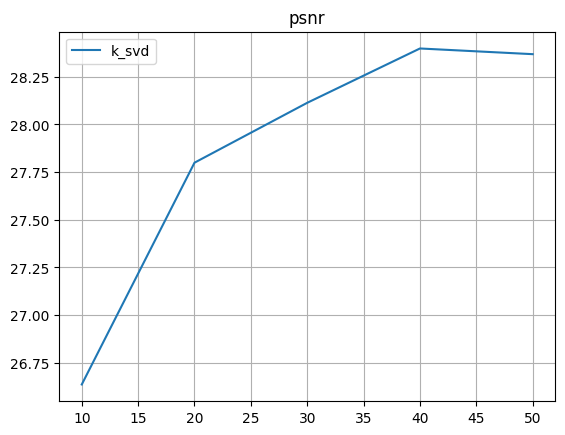

In [237]:
plt.plot([10,20,30,40,50],ps_arr1)
plt.legend(["k_svd"])
plt.grid()
plt.title("psnr")
plt.show()

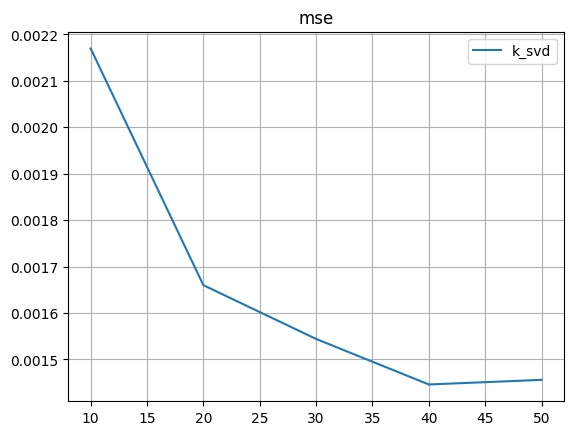

In [239]:
plt.plot([10,20,30,40,50],ps_arr2)
plt.legend(["k_svd"])
plt.grid()
plt.title("mse")
plt.show()